# Notebook Setup

## Import Libraries

In [ ]:
### imports libraries & setup
RANDOM_SEED = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import random
random.seed(RANDOM_SEED)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import logging

import math

import numpy as np
np.random.seed(RANDOM_SEED)

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.layers import Lambda
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(RANDOM_SEED)
tf.compat.v1.set_random_seed(RANDOM_SEED)

import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error

import re

import zipfile

In [ ]:
### cd into the script directory
from google.colab import drive
drive.mount('/content/drive')
os.chdir(HOMEWORK1_PATH)

Mounted at /content/drive


## Helper Functions

In [ ]:
### plots a grid of images
def plot_images(
  images:      list,                # images to display
  captions:    list[str],           # caption of each image
  num_of_cols: int=5,               # number of images per each row
  image_size:  tuple[int]=(3, 3),   # size of each image in inches
):

  num_of_rows = math.ceil(len(images) / num_of_cols)
  fig_size = (image_size[0]*num_of_cols, image_size[1]*num_of_rows)

  fig, axes = plt.subplots(
    nrows=num_of_rows,
    ncols=num_of_cols,
    figsize=fig_size,
  )

  axes = axes.flatten()

  for i in range(num_of_cols*num_of_rows):
    ax = axes[i]

    # disable axis
    ax.axis('off')

    # show the image
    if i < len(images):
      ax.imshow(images[i])
      ax.set_title(captions[i])

  plt.tight_layout()
  plt.show()

In [ ]:
### plots training history
def plot_history(
  history,
  metrics: list[str],
  figsize: tuple[int]=(15,6),
):

  plt.figure(figsize=figsize)

  for metric in metrics:
    plt.plot(history[metric], label=metric)

  plt.legend(loc='upper right')
  plt.grid(alpha=.3)

  plt.show()

# Dataset

## Imports the dataset

In [ ]:
### unzips the dataset
if UNZIP_DATASET is True:
  print('Unzipping the dataset')
  !unzip public_data.zip

In [ ]:
### loads the dataset
dataset = np.load('public_data.npz', allow_pickle=True)
images, labels = dataset['data'], dataset['labels']

## Dataset inspection

In [ ]:
### general infos

# images informations
print(f'"images" array')
print(f'\t- shape: {images.shape}')
print(f'\t- dtype: {images.dtype}')
print(f'\t- range: [{np.min(images)}, {np.max(images)}]')
print()

# labels informations
print(f'"labels" array')
print(f'\t- shape: {labels.shape}')
print(f'\t- labels:')

label_names, label_counts = np.unique(labels, return_counts=True)
tot_count = sum(label_counts)
for i, label in enumerate(label_names):
  count = label_counts[i]
  perc = round(100*count/tot_count, 2)
  print(f'\t\t"{label}": {count}/{tot_count} ({perc}%)')


"images" array
	- shape: (5200, 96, 96, 3)
	- dtype: float32
	- range: [0.0, 255.0]

"labels" array
	- shape: (5200,)
	- labels:
		"healthy": 3199/5200 (61.52%)
		"unhealthy": 2001/5200 (38.48%)


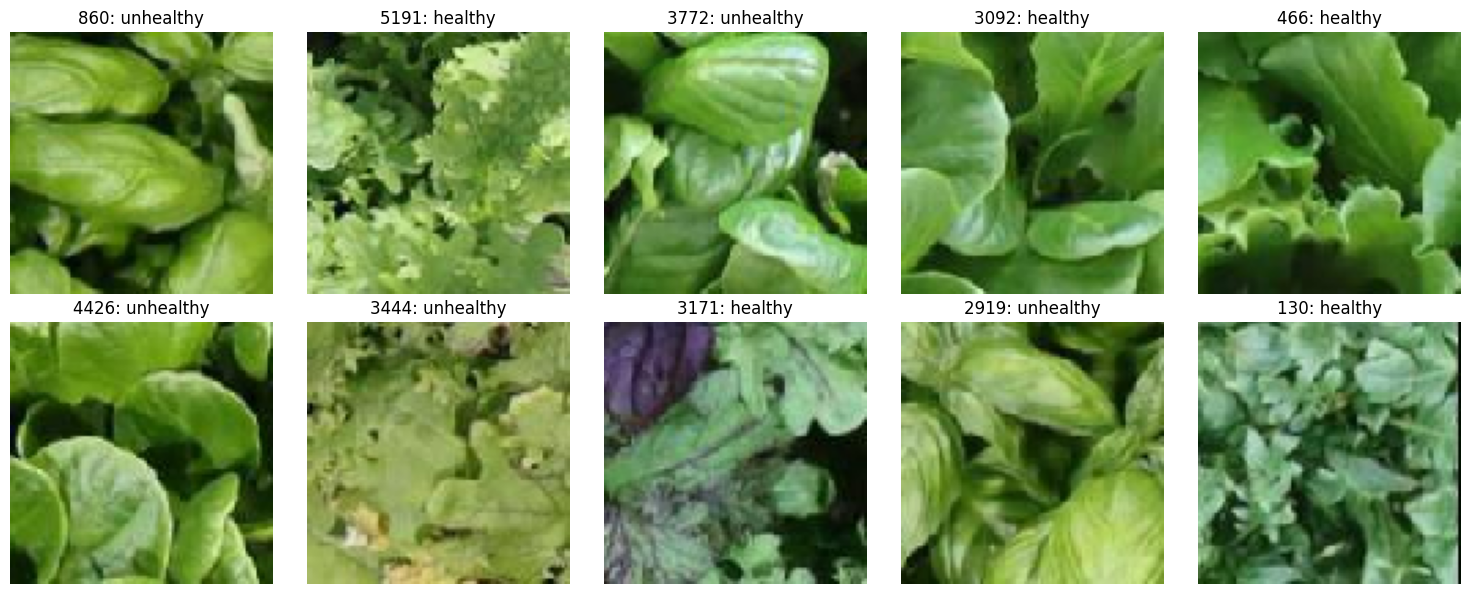

In [ ]:
### shows a random sample of images from the dataset
NUM_OF_IMAGES  = 10
IMAGES_PER_COL = 5


# extracts some random index
indexes = np.random.randint(0, len(images), size=NUM_OF_IMAGES)

# extracts the corresponding images and captions
samples = images[indexes]
captions = np.core.defchararray.add(indexes.astype(str), ': ' + labels[indexes])

plot_images(
  images=samples/255,
  captions=captions,
  num_of_cols=IMAGES_PER_COL,
)

**By inspecting some samples, it turned out that some images are outliers**

## Removes outliers

In [ ]:
### finds all images that are similar to a given reference image
def index_of_similar_images(
  reference,          # image to search
  images,             # array if images
  threshold: float,   # value from 0 to 1 (the closer to 1, the more similar)
):

  from skimage.metrics import structural_similarity as ssim
  from skimage.transform import resize

  # evaluates the similarity score for each image
  similarity_scores = []
  for image in images:
    # resizes the reference image to match the dimensions of the current image
    resized_reference = resize(reference, image.shape, anti_aliasing=True, mode='reflect')
    score = ssim(image, resized_reference, multichannel=True)
    similarity_scores.append(score)

  similarity_scores = np.array(similarity_scores)

  # indexes of scores that are larger than the threshold
  indexes = np.where(similarity_scores >= threshold)[0]

  # sorts the indexes by the corresponding values
  sorted_indexes = indexes[np.argsort(similarity_scores[indexes])]

  return sorted_indexes


In [ ]:
### extracting outliers
# by manually inspecting a couple hundred of images, it turned out that there are
# some outliers. In particular, we found two different classes of outliers: a
# Shrek image (images[58]) and a trololo image (data[898])

OUTLIER_CLASSES = [
  images[58],
  images[898],
]

SIMILARITY_THRESHOLD = 0.9


# finds the indexes of all the outliers
outlier_indexes = []
for outlier in OUTLIER_CLASSES:
  outlier_indexes.extend(index_of_similar_images(
    reference=outlier,
    images=images,
    threshold=SIMILARITY_THRESHOLD,
  ))

# converts the list into a numpy array
outlier_indexes = np.array(outlier_indexes)


# prints the outliers
print(f'{len(outlier_indexes)} have been found:')

plot_images(
  images=images[outlier_indexes]/255,
  captions=outlier_indexes.astype(str),
  num_of_cols=8,
  image_size=(2, 2)
)

In [ ]:
### removing outliers

# uncomment this line to avoid running the last code section, that takes a while
# to run
outlier_indexes = np.array([58, 3688, 3666, 3583, 3572, 3488, 3410, 3286, 3155, 3144, 3770, 3105, 3033, 2937, 2913, 2866, 2864, 2830, 2800, 2779, 2755, 3055, 3801, 3802, 3806, 5082, 4857, 4779, 4740, 4694, 4507, 4476, 4475, 4368, 4282, 4150, 4144, 4118, 4097, 3988, 3946, 3931, 3927, 3885, 3862, 3811, 2736, 2734, 2727, 2675, 1280, 1268, 1265, 1028, 974, 901, 880, 840, 827, 779, 692, 658, 622, 599, 571, 506, 207, 171, 138, 137, 95, 1333, 5121, 1443, 1483, 2665, 2663, 2515, 2453, 2451, 2435, 2380, 2328, 2311, 2261, 2090, 2081, 2022, 1977, 1938, 1866, 1806, 1651, 1594, 1554, 1528, 1466, 5171, 338, 3964, 3950, 3904, 3899, 3896, 3835, 3821, 3800, 3740, 3989, 3700, 3451, 3436, 3376, 3108, 3086, 3049, 2929, 2889, 2839, 3490, 4049, 4055, 4100, 5080, 5048, 4927, 4907, 4903, 4897, 4883, 4860, 4848, 4837, 4766, 4735, 4719, 4618, 4605, 4557, 4503, 4411, 4316, 4314, 4310, 2831, 2796, 2676, 2596, 1191, 1190, 1172, 1149, 1101, 1065, 1064, 1044, 989, 971, 961, 898, 783, 753, 725, 723, 701, 529, 486, 434, 412, 1384, 5143, 1541, 1630, 2593, 2581, 2564, 2496, 2487, 2426, 2348, 2198, 2192, 2191, 2150, 1988, 1981, 1939, 1903, 1828, 1759, 1757, 1752, 1697, 1690, 1609, 5165])

mask = np.ones(len(images), dtype=bool)
mask[outlier_indexes] = False

clean_data = images[mask]
clean_labels = labels[mask]
del images
del labels

In [ ]:
np.save(clean_data, 'clean_data.npy')
np.save(clean_labels, 'clean_labels.npy', allow_pickle = True)

# Split data

In [ ]:
clean_data = np.load('clean_data.npy')
clean_labels = np.load('clean_labels.npy', allow_pickle = True)

Stampiamo numero healthy/unhealthy e rapporto prima della rimozione dei campioni del test set

Ora estraiamo i campioni.

Gli unhealthy sono circa 1900. Il 10% sarebbero 190 -> prendiamone 100 (circa 6%).


Gli healthy sono circa 3100 -> ne prendiamo 100 (circa 3.4%)



In [ ]:
# Example data (replace these with your actual data)
images = clean_data  # Your list of images
labels = clean_labels  # Your list of labels ('healthy' or 'unhealthy')

# Splitting the dataset into healthy and unhealthy with indices
healthy_indices = [i for i, label in enumerate(labels) if label == 'healthy']
unhealthy_indices = [i for i, label in enumerate(labels) if label == 'unhealthy']

# Select N indices from each category
N = 100

selected_healthy_indices = np.random.choice(healthy_indices, N, replace=False)
selected_unhealthy_indices = np.random.choice(unhealthy_indices, N, replace=False)

# Extract selected images and labels
selected_images = [images[i] for i in selected_healthy_indices] + [images[i] for i in selected_unhealthy_indices]
selected_labels = ['healthy'] * N + ['unhealthy'] * N

# Remove selected images and labels from the original dataset
images = [img for i, img in enumerate(images) if i not in selected_healthy_indices and i not in selected_unhealthy_indices]
labels = [lbl for i, lbl in enumerate(labels) if i not in selected_healthy_indices and i not in selected_unhealthy_indices]

# Shuffle selected images and labels
selected_images, selected_labels = np.array(selected_images), np.array(selected_labels)
shuffle_indices = np.random.permutation(len(selected_images))
selected_images = selected_images[shuffle_indices]
selected_labels = selected_labels[shuffle_indices]


Abbiamo ottenuto i due dataset diversi:

```images``` e ```labels``` saranno da augmentare e splittare in train e validation

```selected_images``` e ```selected_labels``` formeranno il train set e non andranno augmentate.

In [ ]:
images[:5]

[array([[[ 20.,  38.,   0.],
         [ 44.,  62.,  22.],
         [151., 173., 127.],
         ...,
         [177., 220., 149.],
         [180., 224., 149.],
         [181., 225., 148.]],
 
        [[ 18.,  35.,   1.],
         [ 12.,  29.,   0.],
         [ 85., 106.,  65.],
         ...,
         [177., 220., 149.],
         [179., 223., 148.],
         [179., 223., 146.]],
 
        [[ 12.,  23.,   6.],
         [  9.,  22.,   2.],
         [  1.,  17.,   0.],
         ...,
         [171., 213., 147.],
         [170., 213., 142.],
         [170., 213., 141.]],
 
        ...,
 
        [[  3.,  13.,   2.],
         [  6.,  16.,   5.],
         [ 11.,  18.,  10.],
         ...,
         [101., 139.,  82.],
         [ 83., 115.,  66.],
         [ 81., 113.,  64.]],
 
        [[  6.,  17.,   0.],
         [  8.,  19.,   2.],
         [ 15.,  23.,   8.],
         ...,
         [ 87., 125.,  68.],
         [ 98., 130.,  80.],
         [ 90., 122.,  73.]],
 
        [[  6.,  18.,   0.],
 

# Data Augmentation

Aumentiamo il numero di immagini di train e validation, applicando l'augment sulle nuove variabili ```images``` e ```labels```.




In [ ]:
def flip_horizontal_and_vertical(image):
    # Flip the image horizontally and vertically
    image = tf.image.flip_left_right(image)
    image = tf.image.flip_up_down(image)
    return image

augment = tf.keras.Sequential([
  #tfkl.RandomZoom(height_factor = 0.1152,width_factor=0.1152,fill_mode='reflect',interpolation='bilinear'),
  tfkl.Lambda(flip_horizontal_and_vertical),
  tfkl.RandomRotation(factor = (-0.05,0.05),fill_mode='reflect',interpolation='bilinear'),
  #tfkl.RandomBrightness(0.2, value_range=(0,1)),
  #tf.keras.layers.RandomContrast(factor = 0.3)
  ])

In [ ]:
### one-hot encode labels
mapping = {
  'healthy': 0,
  'unhealthy': 1,
}

# maps labels according do the mapping
vfunc = np.vectorize(lambda label: mapping[label])

encoded_labels = tf.keras.utils.to_categorical(
  vfunc(labels),
  num_classes=2,
  dtype='float32'
)


# Indici delle etichette 'healthy'
healthy_indices = np.where(encoded_labels[:, 0] == 1)[0]
unhealthy_indices = np.where(encoded_labels[:, 1] == 1)[0]
# Ora healthy_indices conterrà gli indici delle istanze corrispondenti alla classe 'healthy'

# Suddividi l'array data e label in base agli indici
clean_data_healthy = clean_data[healthy_indices]
clean_data_unhealthy = clean_data[unhealthy_indices]
clean_labels_healthy = encoded_labels[healthy_indices]
clean_labels_unhealthy = encoded_labels[unhealthy_indices]

print(f"lunghezza healthy = {len(clean_data_healthy)} e lunghezza unhealthy = {len(clean_data_unhealthy)}")
clean_data_healthy.shape

lunghezza healthy = 3001 e lunghezza unhealthy = 1803


(3001, 96, 96, 3)

In [ ]:
clean_data_healthy2=np.concatenate([clean_data_healthy, augment(clean_data_healthy[0:500])])
clean_data_unhealthy2=np.concatenate([clean_data_unhealthy, augment(clean_data_unhealthy[0:1700])])
clean_labels_healthy=np.concatenate([clean_labels_healthy, clean_labels_healthy[0:500]])
clean_labels_unhealthy=np.concatenate([clean_labels_unhealthy, clean_labels_unhealthy[0:1700]])
print(f"lunghezza healthy = {len(clean_data_healthy2)} e lunghezza unhealthy = {len(clean_data_unhealthy2)}")
print(f"lunghezza healthy = {len(clean_labels_healthy)} e lunghezza unhealthy = {len(clean_labels_unhealthy)}")

lunghezza healthy = 3501 e lunghezza unhealthy = 3503
lunghezza healthy = 3501 e lunghezza unhealthy = 3503


In [ ]:
clean_data2=np.concatenate([clean_data_healthy2, clean_data_unhealthy2])
encoded_labels2=np.concatenate([clean_labels_healthy, clean_labels_unhealthy])
print(f"Shape data = {clean_data2.shape} e lunghezza labels = {encoded_labels2.shape}")

Shape data = (7004, 96, 96, 3) e lunghezza labels = (7004, 2)


# Train, Validation e Test definition

##Train e Validation

Splittiamo i dati augmentati ```clean_data2``` e ```encoded_labels2``` in Train e Validation.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(clean_data2, encoded_labels2, random_state=42, test_size=0.2, stratify=np.argmax(encoded_labels2,axis=1))
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
input_shape = X_train.shape[1:]


X_train shape: (5603, 96, 96, 3), y_train shape: (5603, 2)
X_val shape: (1401, 96, 96, 3), y_val shape: (1401, 2)


##Test

Trasformiamo ```selected_images``` e ```selected_labels``` in X_test e y_test

In [ ]:
### one-hot encode labels
mapping = {
  'healthy': 0,
  'unhealthy': 1,
}

# maps labels according do the mapping
vfunc = np.vectorize(lambda label: mapping[label])

y_test = tf.keras.utils.to_categorical(
  vfunc(selected_labels),
  num_classes=2,
  dtype='float32'
)

In [ ]:
X_test = selected_images

In [ ]:
print(f"X_train shape: {X_test.shape}, y_train shape: {y_test.shape}")

X_train shape: (200, 96, 96, 3), y_train shape: (200, 2)
